In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pytorch_tabnet.tab_model import TabNetClassifier
import numpy as np
from imblearn.over_sampling import SMOTE
import optuna

In [43]:
# Load datasets
red = pd.read_csv("../data/wine+quality/winequality-red.csv", sep=';')
white = pd.read_csv("../data/wine+quality/winequality-white.csv", sep=';')

# Add 'type' feature
red['type'] = 'red'
white['type'] = 'white'

# Combine datasets
df = pd.concat([red, white], ignore_index=True)

# One-hot encode 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Separate features and target
X = df.drop('quality', axis=1)
y = df['quality']

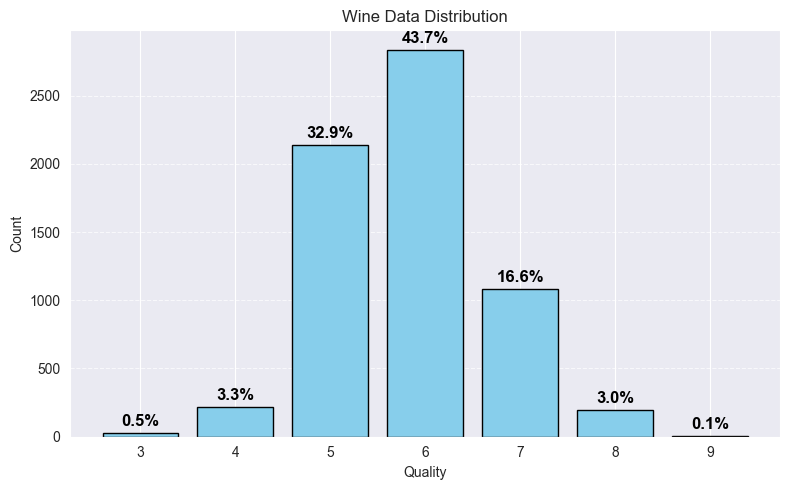

In [44]:
# Visualize distribution.

# Count and ratio
counts = y.value_counts().sort_index()
ratios = counts / counts.sum()

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')

# Add percentage labels on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    ratio = ratios.iloc[i]
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 30,
        f"{ratio:.1%}",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold',
        color='black'  # Force pure white
    )


# Titles and axes
plt.title("Wine Data Distribution")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.xticks(counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [45]:

# Load datasets
red = pd.read_csv("../data/wine+quality/winequality-red.csv", sep=';')
white = pd.read_csv("../data/wine+quality/winequality-white.csv", sep=';')

# Add 'type' feature
red['type'] = 'red'
white['type'] = 'white'

# Combine datasets
df = pd.concat([red, white], ignore_index=True)

# One-hot encode 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

le = LabelEncoder()
y_all = le.fit_transform(df['quality'])

# Separate features and target
X = df.drop('quality', axis=1)
y = df['quality']


# 1. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# 2. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Separate rare classes (e.g., <10 samples)
y_series = pd.Series(y_train).reset_index(drop=True)
X_df = pd.DataFrame(X_train_scaled).reset_index(drop=True)

class_counts = y_series.value_counts()
rare_classes = class_counts[class_counts < 1000].index.tolist()

# 4. Split training data: SMOTE-safe vs rare
mask = ~y_series.isin(rare_classes)
X_safe = X_df[mask].values
y_safe = y_series[mask].values

X_rare = X_df[~mask].values
y_rare = y_series[~mask].values

# 5. Apply SMOTE on SMOTE-safe subset only
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_safe, y_safe)

# 6. Combine all: original + resampled
X_train_final = np.vstack([X_train_scaled, X_smote])
y_train_final = np.hstack([y_train, y_smote])


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [46]:
# Initialize TabNet classifier
clf = TabNetClassifier()

# Train the model
clf.fit(
    X_train=X_train_final, y_train=y_train_final,
    eval_set=[(X_test_scaled, y_test)],
    eval_name=['test'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
    batch_size=256*2,
    virtual_batch_size=128*2,
    num_workers=0,
    drop_last=False
)

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.43517 | test_accuracy: 0.46538 |  0:00:00s
epoch 1  | loss: 1.04292 | test_accuracy: 0.50769 |  0:00:00s
epoch 2  | loss: 0.98452 | test_accuracy: 0.53077 |  0:00:00s
epoch 3  | loss: 0.97266 | test_accuracy: 0.51462 |  0:00:01s
epoch 4  | loss: 0.95135 | test_accuracy: 0.53077 |  0:00:01s
epoch 5  | loss: 0.94819 | test_accuracy: 0.52538 |  0:00:01s
epoch 6  | loss: 0.93681 | test_accuracy: 0.53308 |  0:00:01s
epoch 7  | loss: 0.92687 | test_accuracy: 0.52923 |  0:00:02s
epoch 8  | loss: 0.92044 | test_accuracy: 0.52692 |  0:00:02s
epoch 9  | loss: 0.91475 | test_accuracy: 0.53923 |  0:00:02s
epoch 10 | loss: 0.91327 | test_accuracy: 0.52615 |  0:00:02s
epoch 11 | loss: 0.91277 | test_accuracy: 0.53769 |  0:00:03s
epoch 12 | loss: 0.90813 | test_accuracy: 0.55077 |  0:00:03s
epoch 13 | loss: 0.91067 | test_accuracy: 0.53923 |  0:00:03s
epoch 14 | loss: 0.91701 | test_accuracy: 0.53077 |  0:00:03s
epoch 15 | loss: 0.90267 | test_accuracy: 0.53846 |  0:00:04s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
from sympy.printing.pytorch import torch
import optuna
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score
import torch
import numpy as np

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

np.random.seed(42)


X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_final, y_train_final,
    test_size=0.2, stratify=y_train_final, random_state=42
)

def objective(trial):
    params = {
        "n_d": trial.suggest_categorical("n_d", [8, 16, 32]),
        "n_a": trial.suggest_categorical("n_a", [8, 16, 32]),
        "n_steps": trial.suggest_int("n_steps", 3, 10),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True),
        "optimizer_params": dict(lr=trial.suggest_float("lr", 1e-4, 1e-2, log=True)),
        "mask_type": trial.suggest_categorical("mask_type", ["entmax", "sparsemax"]),
        "batch_size": trial.suggest_categorical("batch_size", [512, 1024]),
        "virtual_batch_size": trial.suggest_categorical("virtual_batch_size", [128, 256]),
    }


    clf = TabNetClassifier(
        n_d=params["n_d"],
        n_a=params["n_a"],
        n_steps=params["n_steps"],
        gamma=params["gamma"],
        lambda_sparse=params["lambda_sparse"],
        optimizer_params=params["optimizer_params"],
        optimizer_fn=torch.optim.Adam,
        mask_type=params["mask_type"],
        verbose=1
    )

    clf.fit(
        X_train=X_train_final, y_train=y_train_final,
        eval_set=[(X_val, y_val)],
        num_workers=0,
        eval_name=["test"],
        eval_metric=["accuracy"],
        max_epochs=100,
        patience=10,
        batch_size=params["batch_size"],
        virtual_batch_size=params["virtual_batch_size"],
        drop_last=False
    )

    preds = clf.predict(X_val)
    acc = accuracy_score(y_val, preds)
    return acc


# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Best results
print("Best trial:")
print(study.best_trial)


[I 2025-05-20 17:23:03,460] A new study created in memory with name: no-name-72376696-287e-40ca-bd10-c39c646c43a1
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.25103 | test_accuracy: 0.26965 |  0:00:00s
epoch 1  | loss: 1.9822  | test_accuracy: 0.3395  |  0:00:00s
epoch 2  | loss: 1.77644 | test_accuracy: 0.36929 |  0:00:01s
epoch 3  | loss: 1.65791 | test_accuracy: 0.39548 |  0:00:01s
epoch 4  | loss: 1.53813 | test_accuracy: 0.43914 |  0:00:01s
epoch 5  | loss: 1.462   | test_accuracy: 0.44633 |  0:00:02s
epoch 6  | loss: 1.37156 | test_accuracy: 0.46893 |  0:00:02s
epoch 7  | loss: 1.3315  | test_accuracy: 0.47355 |  0:00:02s
epoch 8  | loss: 1.28992 | test_accuracy: 0.47355 |  0:00:03s
epoch 9  | loss: 1.25746 | test_accuracy: 0.49153 |  0:00:03s
epoch 10 | loss: 1.225   | test_accuracy: 0.50026 |  0:00:03s
epoch 11 | loss: 1.20128 | test_accuracy: 0.5131  |  0:00:04s
epoch 12 | loss: 1.1912  | test_accuracy: 0.5018  |  0:00:04s
epoch 13 | loss: 1.16995 | test_accuracy: 0.51361 |  0:00:05s
epoch 14 | loss: 1.14187 | test_accuracy: 0.52029 |  0:00:05s
epoch 15 | loss: 1.1324  | test_accuracy: 0.51567 |  0:00:05s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 17:23:24,665] Trial 0 finished with value: 0.6081150487930149 and parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.914804918307322, 'lambda_sparse': 0.00011519349180692886, 'lr': 0.0018679602645197925, 'mask_type': 'sparsemax', 'batch_size': 1024, 'virtual_batch_size': 256}. Best is trial 0 with value: 0.6081150487930149.


epoch 58 | loss: 0.94414 | test_accuracy: 0.59887 |  0:00:21s

Early stopping occurred at epoch 58 with best_epoch = 48 and best_test_accuracy = 0.60812


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.97626 | test_accuracy: 0.31895 |  0:00:00s
epoch 1  | loss: 2.41291 | test_accuracy: 0.41448 |  0:00:01s
epoch 2  | loss: 1.73105 | test_accuracy: 0.47304 |  0:00:01s
epoch 3  | loss: 1.488   | test_accuracy: 0.51361 |  0:00:02s
epoch 4  | loss: 1.2942  | test_accuracy: 0.53313 |  0:00:03s
epoch 5  | loss: 1.21485 | test_accuracy: 0.51875 |  0:00:03s
epoch 6  | loss: 1.14052 | test_accuracy: 0.52851 |  0:00:04s
epoch 7  | loss: 1.10822 | test_accuracy: 0.56343 |  0:00:04s
epoch 8  | loss: 1.07915 | test_accuracy: 0.5547  |  0:00:05s
epoch 9  | loss: 1.07096 | test_accuracy: 0.56754 |  0:00:05s
epoch 10 | loss: 1.05417 | test_accuracy: 0.55624 |  0:00:06s
epoch 11 | loss: 1.04096 | test_accuracy: 0.56343 |  0:00:06s
epoch 12 | loss: 1.02486 | test_accuracy: 0.57422 |  0:00:07s
epoch 13 | loss: 1.01052 | test_accuracy: 0.56754 |  0:00:07s
epoch 14 | loss: 0.99739 | test_accuracy: 0.55213 |  0:00:08s
epoch 15 | loss: 1.00516 | test_accuracy: 0.56138 |  0:00:08s
epoch 16

In [40]:
import numpy as np


best_params = study.best_trial.params
best_model = TabNetClassifier(
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    lambda_sparse=best_params["lambda_sparse"],
    optimizer_params={"lr": best_params["lr"]},
    mask_type=best_params["mask_type"],
    verbose=1
)

best_model.fit(
    X_train=X_train_final, y_train=y_train_final,
    eval_set=[(X_test_scaled, y_test)],
    eval_name=["test"],
    eval_metric=["accuracy"],
    max_epochs=200,
    patience=30,
    batch_size=best_params["batch_size"],
    virtual_batch_size=best_params["virtual_batch_size"],
    num_workers=0,
    drop_last=False
)

test_preds = best_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, test_preds)
print(f"Test accuracy: {test_acc:.4f}")


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.54768 | test_accuracy: 0.48462 |  0:00:00s
epoch 1  | loss: 1.05302 | test_accuracy: 0.51154 |  0:00:01s
epoch 2  | loss: 0.98155 | test_accuracy: 0.52692 |  0:00:02s
epoch 3  | loss: 0.94856 | test_accuracy: 0.53077 |  0:00:02s
epoch 4  | loss: 0.91376 | test_accuracy: 0.54077 |  0:00:03s
epoch 5  | loss: 0.90496 | test_accuracy: 0.55385 |  0:00:04s
epoch 6  | loss: 0.90331 | test_accuracy: 0.55385 |  0:00:04s
epoch 7  | loss: 0.89071 | test_accuracy: 0.54692 |  0:00:05s
epoch 8  | loss: 0.88063 | test_accuracy: 0.55692 |  0:00:06s
epoch 9  | loss: 0.87399 | test_accuracy: 0.55    |  0:00:06s
epoch 10 | loss: 0.86675 | test_accuracy: 0.54923 |  0:00:07s
epoch 11 | loss: 0.86371 | test_accuracy: 0.55692 |  0:00:07s
epoch 12 | loss: 0.84978 | test_accuracy: 0.54538 |  0:00:08s
epoch 13 | loss: 0.85292 | test_accuracy: 0.55538 |  0:00:09s
epoch 14 | loss: 0.84358 | test_accuracy: 0.55231 |  0:00:09s
epoch 15 | loss: 0.85213 | test_accuracy: 0.54769 |  0:00:10s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [41]:
results_df = study.trials_dataframe(attrs=("number", "value", "params", "state"))

results_df.to_csv("tabnet_wine_optuna.csv", index=False)

print("Study results saved to tabnet_wine_optuna.csv")


Study results saved to tabnet_wine_optuna.csv
